# Binary Image Classifier using Scikit-Learn

During the 2020 Covid-19 pandemic many countries declared it mandatory to wear facial masks when moving about in public spaces. This binary classifier aims to classify a .jpg image to determine whether a person is wearing a face mask or not.

### Import the necessary libraries

In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

### Define a function to load the raw data from a target folder and load the images

In [10]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping.")
                continue
            img = cv2.resize(img, (128, 128))  # Resize to a smaller size
            images.append(img)
        except Exception as e:
            print(f"Error: Could not process image {img_path}. Error: {e}")
            continue
    return images

# Load images
mask_images_folder = "/data/notebook_files/Face Masks/Masks"
no_mask_images_folder = "/data/notebook_files/Face Masks/NotMasks"

mask_images = load_images_from_folder(mask_images_folder)
no_mask_images = load_images_from_folder(no_mask_images_folder)

print(f"Loaded {len(mask_images)} mask images.")
print(f"Loaded {len(no_mask_images)} no mask images.")

Loaded 797 mask images.
Loaded 56 no mask images.


### Create labels to classify the images as mask or no_mask

In [11]:
# Create labels
mask_labels = [1] * len(mask_images)  # 1 for mask
no_mask_labels = [0] * len(no_mask_images)  # 0 for no mask

# Combine images and labels
try:
    X = np.array(mask_images + no_mask_images)
    y = np.array(mask_labels + no_mask_labels)
    if X is None or y is None:
        print("Warning: No mask or no mask images were loaded.")
except Exception as e:
    print(f"Warning: Could not process mask images. Error: {e}")

print("Image masks created successfully")

Image masks created successfully


### Split the data into a training and testing set using scikit-learn's test_train_split function (use an 80-20 split)

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train images: {len(X_train)}")
print(f"Test images: {len(X_test)}")

Train images: 682
Test images: 171


### Define a function to extract HOG features from the imported images

Histogram of Oriented Gradients (HOG) is a feature descriptor used in computer vision and image processing for object detection. HOG features are used to capture the shape and structure of objects within an image. 

How HOG Features Work

1. Gradient Computation:

    The first step in computing HOG features is to calculate the gradients of the image. The gradient of an image at a particular pixel is a vector that points in the direction of the greatest rate of increase in intensity and whose magnitude corresponds to the rate of change in that direction.
    Typically, gradients are calculated using the Sobel operator, which applies convolution filters to the image to obtain gradients in both the horizontal (x) and vertical (y) directions.

2. Orientation Binning:

    The gradient orientations (or angles) and magnitudes are then used to create a histogram of gradients. The image is divided into small spatial regions called cells (e.g., 8x8 pixels).
    Within each cell, the gradient orientations are quantized into a fixed number of bins (e.g., 9 bins for orientations ranging from 0 to 180 degrees). The gradient magnitudes are used to vote into the orientation bins.

3. Block Normalization:

    To account for changes in illumination and contrast, the histograms are normalized. This is done by grouping adjacent cells into larger blocks (e.g., 2x2 cells), and then normalizing the gradient values within each block.
    The normalized histograms from all the blocks are concatenated to form the final feature vector for the image.

4. Feature Vector:

    The concatenated histograms from all the blocks form the HOG feature descriptor for the image. This feature vector captures the local shape information and the distribution of gradient orientations.

In [13]:
# Function to extract HOG features using OpenCV
def extract_hog_features(images):
    hog = cv2.HOGDescriptor()
    hog_features = []
    for i, img in enumerate(images):
        try:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            features = hog.compute(gray_img)
            if features is None:
                print(f"Warning: HOG feature computation failed for image index {i}. Skipping.")
                continue
            hog_features.append(features.flatten())
        except Exception as e:
            print(f"Error: Could not process image index {i}. Error: {e}")
            continue
    return np.array(hog_features)

# Extract HOG features from the training and testing datasets
try:
    X_train_features = extract_hog_features(X_train)
    X_test_features = extract_hog_features(X_test)
except Exception as e:
    print(f"Error: Failed to extract HOG features from the dataset. Error: {e}")

# Example: Check the shape of the extracted features
print(f"Extracted HOG features for training set: {X_train_features.shape}")
print(f"Extracted HOG features for testing set: {X_test_features.shape}")

Extracted HOG features for training set: (682, 34020)
Extracted HOG features for testing set: (171, 34020)


## Train and fit a Naive Bays model to classify the images and perform cross-validation using GridsearchCV

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Define the parameter grid to search using GridsearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Add other values as needed
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(nb_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_features, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Get the best Naive Bayes model
best_nb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_nb_model.score(X_test_features, y_test)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'alpha': 100}
Accuracy on Test Set: 0.8128654970760234


## Train and fit a Stochastic Gradient Descent model to classify the images and perform cross-validation using GridsearchCV

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

# Define the SGD model
sgd_model = SGDClassifier(loss='hinge', max_iter=1000)

# Define the parameter grid to search using GridsearchCV
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1]  # Initial learning rate must be > 0
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(sgd_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_features, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Get the best SGD model
best_sgd_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_sgd_model.score(X_test_features, y_test)
print("Accuracy on Test Set:", accuracy)


Best Parameters: {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}
Accuracy on Test Set: 0.9473684210526315


## Train and fit a Logistic Regression model to classify the images and perform cross-validation using GridsearchCV

In [16]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
logistic_model = LogisticRegression()

# Define the parameter grid to search using GridsearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],          # Regularization penalty
    'solver': ['liblinear', 'saga']  # Solver for optimization
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_features, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Get the best logistic regression model
best_logistic_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_logistic_model.score(X_test_features, y_test)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set: 0.935672514619883


## Train and fit a SVM model to classify the images and perform cross-validation using GridsearchCV

In [18]:
 from sklearn.svm import SVC
 
 # Define the SVM model
 svm_model = SVC()
 
 # Define the parameter grid to search using GridsearchCV
 param_grid = {
     'C': [0.1, 1, 10],
     'kernel': ['linear', 'rbf', 'poly'],
     'gamma': ['scale', 'auto']
 }
 
 # Perform GridSearchCV for hyperparameter tuning
 grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)
 grid_search.fit(X_train_features, y_train)
 
 # Print the best parameters found by GridSearchCV
 print("Best Parameters:", grid_search.best_params_)
 
 # Get the best SVM model
 best_svm_model = grid_search.best_estimator_
 
 # Evaluate the best model on the test set
 accuracy = best_svm_model.score(X_test_features, y_test)
 print("Accuracy on Test Set:", accuracy)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy on Test Set: 0.9298245614035088


## Compare the accuracy of the different trained models to determine the best performing model

Accuracy on Test Set:
Naive Bays: 0.8128654970760234
SVM: 0.9298245614035088
SGD: 0.9473684210526315
Logistic Regression: 0.935672514619883
Best performing model: SGD with accuracy: 0.9473684210526315


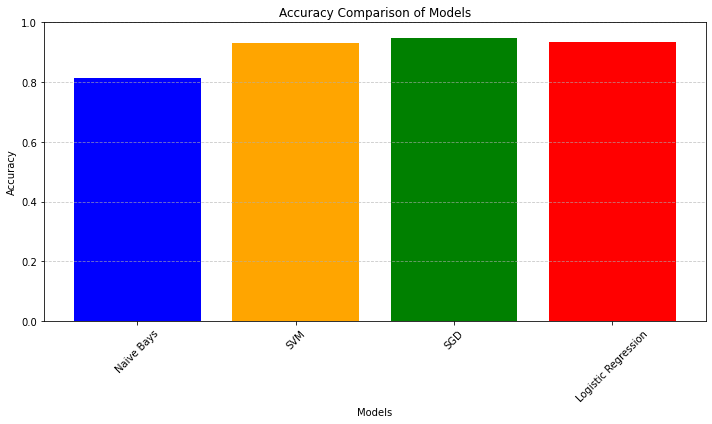

In [19]:
import matplotlib.pyplot as plt

# 1. Evaluate Models on Test Set
nb_accuracy = best_nb_model.score(X_test_features, y_test)
svm_accuracy = best_svm_model.score(X_test_features, y_test)
sgd_accuracy = best_sgd_model.score(X_test_features, y_test)
logistic_accuracy = best_logistic_model.score(X_test_features, y_test)

# 2. Compare Accuracy
print("Accuracy on Test Set:")
print("Naive Bays:", nb_accuracy)
print("SVM:", svm_accuracy)
print("SGD:", sgd_accuracy)
print("Logistic Regression:", logistic_accuracy)

# Determine the best performing model
models = ['Naive Bays', 'SVM', 'SGD', 'Logistic Regression']
accuracies = [nb_accuracy, svm_accuracy, sgd_accuracy, logistic_accuracy]

best_model_index = accuracies.index(max(accuracies))
best_model_name = models[best_model_index]

print("Best performing model:", best_model_name, "with accuracy:", max(accuracies))

# 3. Plot Histogram
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
import joblib

trained_model = best_sgd_model

# Define paths to save the model and scaler
MODEL_PATH = 'binary_image_classifier.pkl'

# Save the pre-trained model
joblib.dump(trained_model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Load the model and scaler to ensure they were saved correctly
loaded_model = joblib.load(MODEL_PATH)
print(f"Model loaded successfully from {MODEL_PATH}")


Model saved to binary_image_classifier.pkl
Model loaded successfully from binary_image_classifier.pkl
